In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tqdm
import h5py
import numpy as np
import tensorflow as tf
#import tensorflow_addons as tfa
import skimage.transform as st
import skimage.filters as sf
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [2]:
# Select global values for the normalisation
min_value = 0.01
max_value = 0.90
npix = 192

In [3]:
# Gaussian smoothing of binned images
sigma_gauss = 0.0

# These give the lower and upper cut values for each map
min_feature = np.array([5.5,5.5,4.0,-0.5,-10.0,2.5])
max_feature = np.array([9.5,8.5,7.5,1.14,-1.5,6.5])
cut_feature = 10.**np.array([5.5,5.5,4.0,-0.5,-10.0,2.5])
min_feature[3] = 10.**min_feature[3]
max_feature[3] = 10.**max_feature[3]
min_feature[4] = 10.**min_feature[4]
max_feature[4] = 10.**max_feature[4]

In [4]:
max_label = -15.5
min_label = -21.5

# First the features

In [7]:
# Load file for features
image_file = h5py.File('C:/Users/simin/Documents/studium/Thesis/images_intrinsic_binned.h5','r')

# Get all systems (galaxies) in this file
system_names = list(image_file.keys())
print(f'System Names = {system_names}\n')


        
map_names = image_file[list(image_file.keys())[0]][list(image_file[list(image_file.keys())[0]].keys())[0]].attrs['Maps']
nmaps = len(map_names)
print(f'Map Names ={map_names}\n')

X = np.empty((0, npix, npix, nmaps))

for system_name in system_names:
    system = image_file[system_name]
    projection_names = list(system.keys())
    for projection_name in projection_names:
        # Get full image
        full_image = np.array(system[projection_name])
        # Clip the image values
        for i in range(nmaps): full_image[:,:,i] = np.where(full_image[:,:,i] < cut_feature[i], cut_feature[i], full_image[:,:,i])
        # Get log surface density
        full_image[:,:,0] = np.log10(full_image[:,:,0])
        full_image[:,:,1] = np.log10(full_image[:,:,1])
        full_image[:,:,2] = np.log10(full_image[:,:,2])
        full_image[:,:,5] = np.log10(full_image[:,:,5])
        # Normalize and Clip
        full_image = (full_image - min_feature) / (max_feature - min_feature) * (max_value - min_value) + min_value 
        full_image[full_image < min_value] = min_value
        full_image[full_image > max_value] = max_value
        # Resize
        full_image = st.resize(full_image,(npix,npix),order=3,anti_aliasing=True,preserve_range=True)
        # Combine
        X = np.concatenate([X, full_image.reshape(1, npix, npix, nmaps)], axis=0)
            

X = np.transpose(X, (0,2,1,3)).astype(np.float32)
print(X.shape, X.min(), X.max, X.mean)

image_file.close()

System Names = ['g1.08e11', 'g1.12e12', 'g1.37e11', 'g1.52e11', 'g1.59e11', 'g1.77e12', 'g1.92e12', 'g2.41e11', 'g2.42e11', 'g2.57e11', 'g2.79e12', 'g3.06e11', 'g3.49e11', 'g5.38e11', 'g6.96e11', 'g7.08e11', 'g7.55e11', 'g7.66e11', 'g8.13e11', 'g8.26e11']

Map Names =['Sigma_stars' 'Sigma_gas' 'Sigma_SFR' 'Mean_age' 'Mean_metals' 'Mean_T']

(219, 192, 192, 6) 0.01 <built-in method max of numpy.ndarray object at 0x0000024F99123F80> <built-in method mean of numpy.ndarray object at 0x0000024F99123F80>


# And now the labels

In [8]:
# Load file for labels
image_file = h5py.File('C:/Users/simin/Documents/studium/Thesis/images_withdust_AB.h5','r')

# Get all systems (galaxies) in this file
system_names = list(image_file.keys())
print(f'System Names = {system_names}\n')


filter_names = image_file[list(image_file.keys())[0]][list(image_file[list(image_file.keys())[0]].keys())[0]].attrs['Filters']
nfilters = len(filter_names)
print(f'Filter Names ={filter_names}\n')

y = np.empty((0, npix, npix, nfilters))

for system_name in system_names:
    system = image_file[system_name]
    projection_names = list(system.keys())
    for projection_name in projection_names:
        # Get full image
        full_image = np.array(system[projection_name])
        # Clip the image values
        full_image = np.where(full_image < 10.**min_label, 10.**min_label, full_image)
        # Get log surface density
        full_image = np.log10(full_image)
        # Normalize and clip
        full_image = (full_image - min_label) / (max_label - min_label) * (max_value - min_value) + min_value 
        full_image[full_image < min_value] = min_value
        full_image[full_image > max_value] = max_value
        # Resize
        full_image = st.resize(full_image,(npix,npix),order=3,anti_aliasing=True,preserve_range=True)
        # Combine
        y = np.concatenate([y, full_image.reshape(1, npix, npix, nfilters)], axis=0)
              

y = np.transpose(y, (0,2,1,3)).astype(np.float32)
print(y.shape, y.min(), y.max, y.mean)

image_file.close()

System Names = ['g1.08e11', 'g1.12e12', 'g1.37e11', 'g1.52e11', 'g1.59e11', 'g1.77e12', 'g1.92e12', 'g2.41e11', 'g2.42e11', 'g2.57e11', 'g2.79e12', 'g3.06e11', 'g3.49e11', 'g5.38e11', 'g6.96e11', 'g7.08e11', 'g7.55e11', 'g7.66e11', 'g8.13e11', 'g8.26e11']

Filter Names =['u' 'g' 'r' 'i' 'z']

(219, 192, 192, 5) 0.01 <built-in method max of numpy.ndarray object at 0x0000024F8E3E6EE0> <built-in method mean of numpy.ndarray object at 0x0000024F8E3E6EE0>


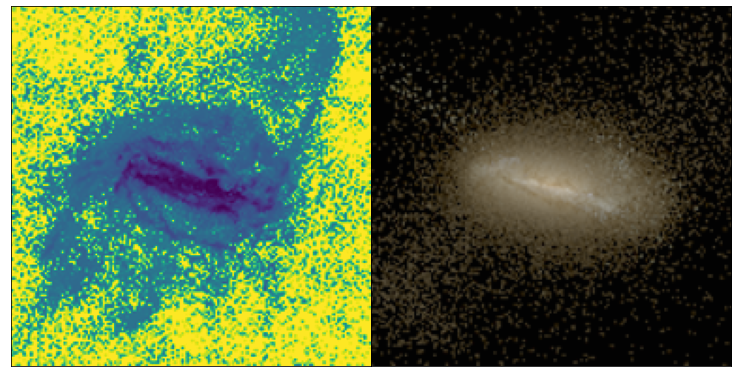

In [9]:
nr = 172
mm = 5

plt.figure(figsize=(10,20))

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

ax1.imshow(X[nr,:,:,mm], vmin=min_value, vmax=max_value)
ax2.imshow(np.transpose(y[nr],(0,1,2))[:,:,[2,1,0]], vmin=min_value, vmax=max_value)

for ax in [ax1,ax2]:
    ax.tick_params(labelleft=False, labelbottom=False, labeltop=False, labelright=False)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0, hspace=0.0, wspace=0.0)

# building U-Net Model

In [10]:
width = 192
height = 192
channels = 6

In [11]:
inputs = tf.keras.layers.Input((width, height, channels))

In [12]:
# Encoding path


c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPool2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPool2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPool2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(c4)

#c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
#c5 = tf.keras.layers.Dropout(0.2)(c5)
#c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
#p5 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(c5)


In [13]:
# Decoding path


u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(1, 1), padding='same')(c4)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

In [14]:
outputs = tf.keras.layers.Conv2D(5, (3,3), activation='sigmoid', padding='same')(c9)

In [15]:
print('Inputs shape: ', inputs.shape)
print('Output shape: ', outputs.shape)

Inputs shape:  (None, 192, 192, 6)
Output shape:  (None, 192, 192, 5)


In [16]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='MSE')
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 6) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 192, 32) 1760        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 192, 192, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 32) 9248        dropout[0][0]                    
_______________________________________________________________________________________

In [17]:
#model.save()
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('logs/model.{epoch:03d}-{val_loss:.6f}.h5', verbose=1, monitor = 'val_loss', save_best_only = True, save_weights_only = True),
    tf.keras.callbacks.EarlyStopping(patience = 35, monitor = 'val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir = 'logs')
]

In [18]:
results = model.fit(X,y, validation_split=0.20, batch_size=10, epochs=350, callbacks=callbacks)

Epoch 1/350
 1/18 [>.............................] - ETA: 0s - loss: 0.1833WARNING:tensorflow:From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
18/18 [==============================] - ETA: 0s - loss: 0.0444
Epoch 00001: val_loss improved from inf to 0.00839, saving model to logs\model.001-0.008394.h5
18/18 [==============================] - 52s 3s/step - loss: 0.0444 - val_loss: 0.0084
Epoch 2/350
18/18 [==============================] - ETA: 0s - loss: 0.0074
Epoch 00002: val_loss improved from 0.00839 to 0.00541, saving model to logs\model.002-0.005414.h5
18/18 [==============================] - 51s 3s/step - loss: 0.0074 - val_loss: 0.0054
Epoch 3/350
18/18 [==============================] - ETA: 0s - loss: 0.0052
Epoch 00003: val_loss improved from 0.00541 to 0.00418, sav

18/18 [==============================] - ETA: 0s - loss: 0.0021
Epoch 00033: val_loss improved from 0.00192 to 0.00191, saving model to logs\model.033-0.001911.h5
18/18 [==============================] - 61s 3s/step - loss: 0.0021 - val_loss: 0.0019
Epoch 34/350
18/18 [==============================] - ETA: 0s - loss: 0.0021
Epoch 00034: val_loss improved from 0.00191 to 0.00189, saving model to logs\model.034-0.001888.h5
18/18 [==============================] - 60s 3s/step - loss: 0.0021 - val_loss: 0.0019
Epoch 35/350
18/18 [==============================] - ETA: 0s - loss: 0.0021
Epoch 00035: val_loss did not improve from 0.00189
18/18 [==============================] - 63s 3s/step - loss: 0.0021 - val_loss: 0.0019
Epoch 36/350
18/18 [==============================] - ETA: 0s - loss: 0.0021
Epoch 00036: val_loss did not improve from 0.00189
18/18 [==============================] - 66s 4s/step - loss: 0.0021 - val_loss: 0.0019
Epoch 37/350
18/18 [==============================] - ETA

18/18 [==============================] - ETA: 0s - loss: 0.0018
Epoch 00068: val_loss did not improve from 0.00163
18/18 [==============================] - 65s 4s/step - loss: 0.0018 - val_loss: 0.0017
Epoch 69/350
18/18 [==============================] - ETA: 0s - loss: 0.0018
Epoch 00069: val_loss did not improve from 0.00163
18/18 [==============================] - 65s 4s/step - loss: 0.0018 - val_loss: 0.0018
Epoch 70/350
18/18 [==============================] - ETA: 0s - loss: 0.0018
Epoch 00070: val_loss did not improve from 0.00163
18/18 [==============================] - 64s 4s/step - loss: 0.0018 - val_loss: 0.0017
Epoch 71/350
18/18 [==============================] - ETA: 0s - loss: 0.0018
Epoch 00071: val_loss did not improve from 0.00163
18/18 [==============================] - 67s 4s/step - loss: 0.0018 - val_loss: 0.0017
Epoch 72/350
18/18 [==============================] - ETA: 0s - loss: 0.0017
Epoch 00072: val_loss did not improve from 0.00163
18/18 [==================

Epoch 105/350
18/18 [==============================] - ETA: 0s - loss: 0.0016
Epoch 00105: val_loss did not improve from 0.00150
18/18 [==============================] - 78s 4s/step - loss: 0.0016 - val_loss: 0.0015
Epoch 106/350
18/18 [==============================] - ETA: 0s - loss: 0.0016
Epoch 00106: val_loss did not improve from 0.00150
18/18 [==============================] - 77s 4s/step - loss: 0.0016 - val_loss: 0.0015
Epoch 107/350
18/18 [==============================] - ETA: 0s - loss: 0.0016
Epoch 00107: val_loss did not improve from 0.00150
18/18 [==============================] - 77s 4s/step - loss: 0.0016 - val_loss: 0.0015
Epoch 108/350
18/18 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00108: val_loss did not improve from 0.00150
18/18 [==============================] - 76s 4s/step - loss: 0.0015 - val_loss: 0.0015
Epoch 109/350
18/18 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00109: val_loss did not improve from 0.00150
18/18 [

18/18 [==============================] - ETA: 0s - loss: 0.0014
Epoch 00142: val_loss did not improve from 0.00142
18/18 [==============================] - 86s 5s/step - loss: 0.0014 - val_loss: 0.0014
Epoch 143/350
18/18 [==============================] - ETA: 0s - loss: 0.0014
Epoch 00143: val_loss did not improve from 0.00142
18/18 [==============================] - 87s 5s/step - loss: 0.0014 - val_loss: 0.0016
Epoch 144/350
18/18 [==============================] - ETA: 0s - loss: 0.0014
Epoch 00144: val_loss did not improve from 0.00142
18/18 [==============================] - 85s 5s/step - loss: 0.0014 - val_loss: 0.0014
Epoch 145/350
18/18 [==============================] - ETA: 0s - loss: 0.0014
Epoch 00145: val_loss did not improve from 0.00142
18/18 [==============================] - 85s 5s/step - loss: 0.0014 - val_loss: 0.0015
Epoch 146/350
18/18 [==============================] - ETA: 0s - loss: 0.0014
Epoch 00146: val_loss did not improve from 0.00142
18/18 [==============

18/18 [==============================] - ETA: 0s - loss: 0.0014
Epoch 00179: val_loss did not improve from 0.00139
18/18 [==============================] - 70s 4s/step - loss: 0.0014 - val_loss: 0.0014
Epoch 180/350
18/18 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00180: val_loss did not improve from 0.00139
18/18 [==============================] - 71s 4s/step - loss: 0.0013 - val_loss: 0.0014
Epoch 181/350
18/18 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00181: val_loss did not improve from 0.00139
18/18 [==============================] - 72s 4s/step - loss: 0.0013 - val_loss: 0.0014
Epoch 182/350
18/18 [==============================] - ETA: 0s - loss: 0.0014
Epoch 00182: val_loss did not improve from 0.00139
18/18 [==============================] - 70s 4s/step - loss: 0.0014 - val_loss: 0.0015
Epoch 183/350
18/18 [==============================] - ETA: 0s - loss: 0.0014
Epoch 00183: val_loss did not improve from 0.00139
18/18 [==============

18/18 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00216: val_loss did not improve from 0.00137
18/18 [==============================] - 76s 4s/step - loss: 0.0013 - val_loss: 0.0014
Epoch 217/350
18/18 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00217: val_loss did not improve from 0.00137
18/18 [==============================] - 76s 4s/step - loss: 0.0013 - val_loss: 0.0014
Epoch 218/350
18/18 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00218: val_loss did not improve from 0.00137
18/18 [==============================] - 76s 4s/step - loss: 0.0013 - val_loss: 0.0014
Epoch 219/350
18/18 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00219: val_loss did not improve from 0.00137
18/18 [==============================] - 76s 4s/step - loss: 0.0013 - val_loss: 0.0014
Epoch 220/350
18/18 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00220: val_loss did not improve from 0.00137
18/18 [==============

Epoch 254/350
18/18 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00254: val_loss did not improve from 0.00135
18/18 [==============================] - 70s 4s/step - loss: 0.0013 - val_loss: 0.0014
Epoch 255/350
18/18 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00255: val_loss did not improve from 0.00135
18/18 [==============================] - 70s 4s/step - loss: 0.0013 - val_loss: 0.0014
Epoch 256/350
18/18 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00256: val_loss did not improve from 0.00135
18/18 [==============================] - 70s 4s/step - loss: 0.0013 - val_loss: 0.0014
Epoch 257/350
18/18 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00257: val_loss improved from 0.00135 to 0.00134, saving model to logs\model.257-0.001339.h5
18/18 [==============================] - 71s 4s/step - loss: 0.0013 - val_loss: 0.0013
Epoch 258/350
18/18 [==============================] - ETA: 0s - loss: 0.0013
Epoch 0025

Epoch 292/350
18/18 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00292: val_loss did not improve from 0.00134
18/18 [==============================] - 63s 4s/step - loss: 0.0013 - val_loss: 0.0013


In [19]:
y_pre = model.predict(X)

In [20]:
print(y_pre.shape)

(219, 192, 192, 5)


In [21]:
def res_calculator(image_num, filter_num):
    
    y1=y[image_num,:,:,filter_num]
    y2=y_pre[image_num,:,:,filter_num]
    error=(y1-y2/y1)
    
    y1_norm=np.linalg.norm(y1)
    y2_norm=np.linalg.norm(y2)
    error_norm=np.linalg.norm(error)/(192*192)
    return [y1_norm, y2_norm, error_norm]

In [22]:
l1=[]
l2=[]
l3=[]
l4=[]
l5=[]


for i in range (0,219):
    res_1=res_calculator(i, 0)
    res_2=res_calculator(i, 1)
    res_3=res_calculator(i, 2)
    res_4=res_calculator(i, 3)
    res_5=res_calculator(i, 4)
    
    l1.append(res_1[2])
    l2.append(res_2[2])
    l3.append(res_3[2])
    l4.append(res_4[2])
    l5.append(res_5[2])

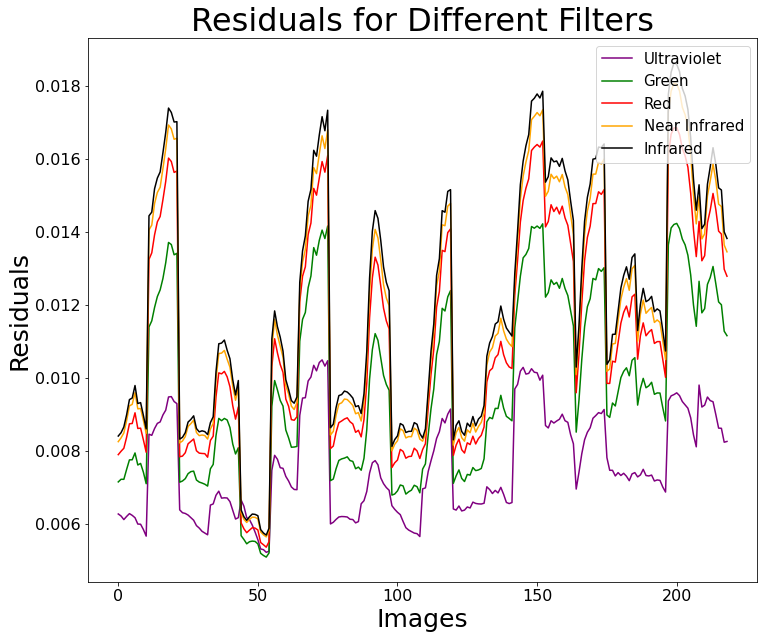

In [27]:
x=list(range(0,219))

plt.figure(figsize=(12,10))

plt.plot(x,l1, color='purple')
plt.plot(x,l2, color='green')
plt.plot(x,l3, color='red')
plt.plot(x,l4, color='orange')
plt.plot(x,l5, color='black')

plt.title('Residuals for Different Filters', fontsize=32)
plt.ylabel('Residuals', fontsize=25)
plt.xlabel('Images', fontsize=25)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

plt.legend(['Ultraviolet', 'Green', 'Red', 'Near Infrared', 'Infrared'], loc='upper right', fontsize=15)

plt.show()

In [24]:
l2.index(max(l2))

200

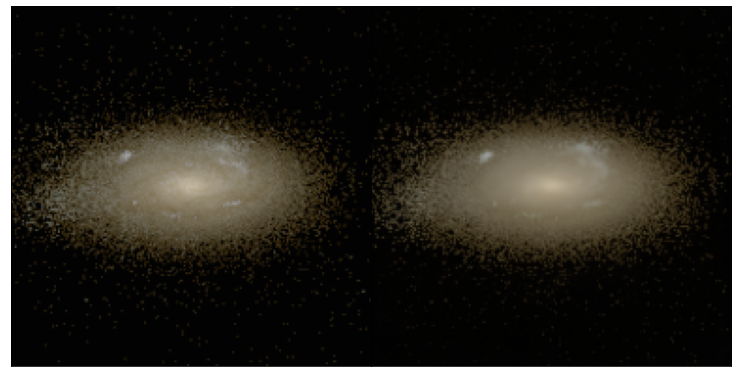

In [25]:
nr = 104
mm = 5

plt.figure(figsize=(10,20))

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

#ax1.imshow(X[nr,:,:,mm], vmin=min_value, vmax=max_value)
ax1.imshow(np.transpose(y[nr],(0,1,2))[:,:,[2,1,0]], vmin=min_value, vmax=max_value)
ax2.imshow(np.transpose(y_pre[nr],(0,1,2))[:,:,[2,1,0]], vmin=min_value, vmax=max_value)

for ax in [ax1,ax2]:
    ax.tick_params(labelleft=False, labelbottom=False, labeltop=False, labelright=False)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0, hspace=0.0, wspace=0.0)

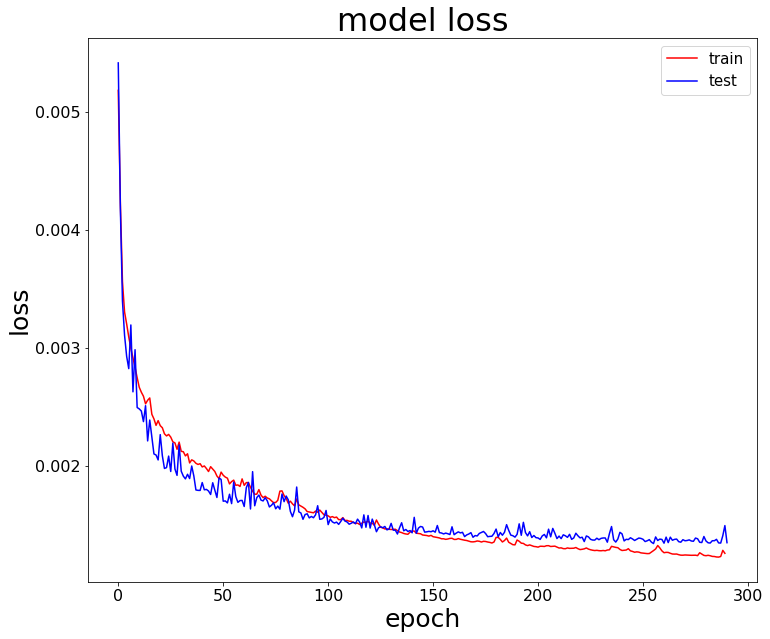

In [33]:
a=results.history['loss']
del a[0]

b=results.history['val_loss']
del b[0]

plt.figure(figsize=(12,10))
plt.plot(a, color='red')
plt.plot(b, color='blue')
plt.title('model loss', fontsize=32)
plt.ylabel('loss', fontsize=25)
plt.xlabel('epoch', fontsize=25)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.legend(['train', 'test'], loc='upper right', fontsize=15)

plt.show()